## Analyze A/B Test Results


For this Udacity project, I run A/B testing on data from a fictious e-commerce website to test the efficacy of a new webpage design. 

A/B testing is essentially running a randomized control trial (econ lingo) and using hypothesis testing to see if the treatment group (new webpage) is more effective than the control group (original web page). 

I first manually find the p-value that shows there is not a statistically significant difference between the new and original pages.
Then, I use the statsmodels.api built-in to produce the same result.
After, I run a logistic regression to validate my previous results.
Lastly, I merge in a dataset on user's location and merge it with the original dataframe and run another regression with interactions.


### Part I: Descriptive Statistics

In [28]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# Setting the seed to assure the same numbers on future executions of this code
random.seed(42)

In [29]:
# Read in the dataset and inspect the first few rows
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


I examine the new data with .head(), which shows me the first five observations. I see there are 5 column/variables

In [30]:
df.shape[0]

294478

I use .shape[0] to find the number of rows. .shape[] will return the ordered pair (rows, columns)

In [31]:
df.user_id.nunique()

290584

I use .nunique() to find the user_id that are unique. It appears that 290,584 / 294,478 observations come from a unique user_id.

In [32]:
converted = df[df['converted']==1].user_id.nunique() / df.user_id.nunique()
converted

0.12104245244060237

I use only unique users to computer the proportion of users converted to avoid repeats. The conversion rate for the entire dataset is ~12.1%. 

In [33]:
df[(df['group']=="treatment") & (df['landing_page']=="old_page")].shape[0] \
    + \
    df[(df['group']=="control") & (df['landing_page']=="new_page")].shape[0]

3893

I check to see if there are any errors in that data. The 'treatment' is exposing the user to the 'new_page'.

 It appears that 3,893 observations in the dataset are coded incorrectly and should be dropped. I find this by checking for orbservations in the 'treatment' group seeing 'old page' or the 'control group' seeing 'new page'.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


I check for missing values using .info(), which returns the number of non-missing observations for each column/variable. Of the 294,478 observations, all 5 of the column/variables have 294,478 observations. Therefore, there are no missing values.

In [35]:
# I remove the observations that may be coding errors by creating two subset dataframes: 'treatment' and 'control'.
treatment= df[(df['group']=="treatment") & (df['landing_page']=="new_page")]
control = df[(df['group']=="control") & (df['landing_page']=="old_page")]

# I them append (concatenate) one to the other and rename it df2. I continue the analysis for the project with df2.
df_test=pd.concat([treatment,control])
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [36]:
# I verify all of the correct rows were removed by re-running my previous code and ensuring it returns 0 observations
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [37]:
# I check the number of unique users in the new dataframe
df2.user_id.nunique() , df2.shape[0]

(290584, 290585)

There are 290,584 unique users in df2 out of a total of 290,585 users. Thus, there is 1 user repeated in the dataset

In [38]:
# I use .duplicated() and specify to find duplicate rows based on column/variable 'user_id'. 
dup = df2[df2.duplicated(['user_id'])]['user_id']
dup

2893    773192
Name: user_id, dtype: int64

The one 'user_id' that is repeated twice in df2 is #773192

In [39]:
# I check the row information for the repeat user_id 
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


It appears the duplicate user visited the new_page twice, on 2017-01-09 and 2017-01-14.

In [40]:
# I drop one of the two repeated user_id so that the dataset is composed of only unique observations one visit per user_id). 
df2=df2.drop([2893])
# I confirm the drop was successful by verifying that the number of unique observations in the data frame is equal to the 
# rows/observations. 
df2.user_id.nunique() == df2.shape[0]

True

In [41]:
# I find the probability of an individual converting regardless of the page they receive by taking the proportion of
# converted individuals relative to the number of individuals in the entire dataframe.
overall_cr = len(df2.query('converted == 1')) / len(df2)
overall_cr

0.11959708724499628

The probability of conversion among the entire dataframe is 11.96%. 

In [42]:
# I find the probability of being converted given that an individual is in the 'control' grup by taking the 
# proportion of converted individuals in the control group relative to the total number of individuals in the control group.
control_cr = len(df2.query('converted == 1 & group == "control"')) / len(df2.query('group == "control"'))
control_cr

0.1203863045004612

The probability of conversion conditional on being in the control group is ~12.04%. 

In [43]:
# I find the probability of being converted given that an individual is in the treatment group by taking the proportion of 
# converted individuals in the treatment group relative to the total number of individuals in the treatment group.
treatment_cr = len(df2.query('converted == 1 & group == "treatment"')) / len(df2.query('group == "treatment"'))

The probability of conversion conditional on being in the treatment group is 11.88%.

In [44]:
# I find the probability that an individual received the new page by taking the proportion of individuals with 'landing_page' 
# as 'new_page' relative to the total number of individuals in the entire data frame.
new_page = len(df2.query('landing_page == "new_page"'))/ len(df2)
new_page

0.5000619442226688

The probability of an individual receiving the new page is approximately 50%.

Based on the descriptive statistics above, I do not believe there is sufficient evidence to conclude that the new treatment page leads to more conversions. We can observe that there is a lower proportion of conversions among the treatment group than there is for the control group. This suggests the new page may not be as effective. However, we should conduct a hypothesis test to make statistical inference. 

<a id='ab_test'></a>
### Part II - A/B Test

I can set up a hypothesis test to see if the new page is signficantly better than the old page. 

**$H_{o}$** : **$p_{new}$** - **$p_{old}$** <= 0 
<br> **$H_{a}$** : **$p_{new}$** - **$p_{old}$** > 0

I will first perform the hypothesis test step-by-step to demonstrate conceputal understanding and then use a simple pre-made function.

To empirically test this, I will draw random samples from the new (treated) and old (control) pages and get the sampling
difference 10,000 times.

The probability of conversion among the entire dataframe is 11.96%. 
I found this by taking the proportion of converted individuals relative to the number of individuals in the entire dataframe
in previous codes above.

In [45]:
overall_cr

0.11959708724499628

The probability of conversion among the entire dataframe is 11.96%. 
I found this by taking the proportion of converted individuals relative to the number of individuals in the entire dataframe.
We assume that under the null hypothesis, the conversion rate for the new page is no bigger than that of the old page. That is, the null is assuming there in no effect or that the new page is less effective at than the old page in terms of conversion rates.

In [46]:
# The number of individuals in the treatment group is below
new_size = df2.query('group == "treatment"').shape[0]
new_size

145310

In [47]:
# The number of individuals in the control group is below
old_size = df2.query('group == "control"').shape[0]
old_size

145274

I simulate the new transactions with a conversion rate the same as that for the overall conversion rate under the null, and store them as binary.


In [61]:
new_page_converted = random.choices([0,1], weights=[1-overall_cr, overall_cr], k=new_size)
new_page_converted = np.array(new_page_converted)
new_page_converted.mean()

0.11968205904617714

In [62]:
# I do the same as above, but for the old page conversion (control group)
old_page_converted = random.choices([0,1], weights=[1-overall_cr, overall_cr], k=old_size)
old_page_converted = np.array(old_page_converted)
old_page_converted.mean()

0.11987692222971763

In [24]:
new_page_converted.mean() - old_page_converted.mean()

-0.0010895414546477633

I now run a simulation by randomly generating the datasets for new_page and old_page sample sizes with each having the likelihood of a converstion identical to the total dataset (new and old page combined). I chose to use a binomial function, setting the probability of success (conversion) equal to that of the overall dataset. 

In [63]:
p_diffs = []
new_converted_sim = np.random.binomial(new_size, overall_cr, 10000)/new_size
old_converted_sim = np.random.binomial(old_size, overall_cr, 10000)/new_size
p_diffs = new_converted_sim - old_converted_sim

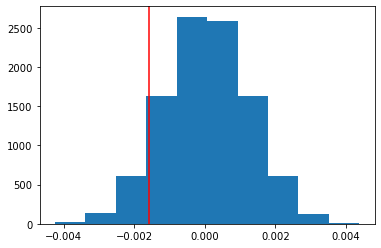

In [64]:
# I convert the list generated in the simulation to an numpy array and plot it. 
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

# I put a red line where the actual difference observed in the ab_data.csv occurs (the actual experiment). 
plt.axvline(x=(treatment_cr - control_cr), color='red');
# This line falls to the left of the median for the randomly generated draws. 

In [70]:
(p_diffs > (treatment_cr - control_cr)).mean()

0.91

I have calculated the 'p-value', which is the likelihood that we incorrectly reject the null hypothesis. 
Typically, practioners are willing to accidently reject the null 5% of the time. The p-value of 0.91 suggests that there is not statistically significant evidence that the new page led to a higher conversion rate than the old page. 

In [72]:
# I now use a built-in to achieve similar results. 
import statsmodels.api as sm

# Calculate the numer of conversions in each group
convert_old = len(df2.query('converted == 1 & group == "control"'))
convert_new = len(df2.query('converted == 1 & group == "treatment"'))
# Calcuate the number of individuals who received each page
n_old = len(df2.query('group == "control"'))
n_new = len(df2.query('group == "treatment"'))

In [73]:
# I use `stats.proportions_ztest` to compute the test statistic and p-value.  
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],  alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

The critical value for a z-score with type 1 error of 5% is 1.64. The z-score from this z-test is 1.31, which is not large enough to reject the null hypothesis. This result is consistent with the manual finding above, that there is not statistical evidence that the new page led to higher conversions that the old.

### Part III - Regression approach


I now show that the same result achieved above can be also found by performing regression. 
Since each row is either a conversion or no conversion, a binary outcome, I use a logistic regression.

I use statsmodels to fit the regression model I specified above to see if there is a significant difference 
in conversion based on which page a customer receives. 

In [75]:
# I define a new column for the intercept
df2['intercept']=1
# I create a dummy variable column for which page each user received, which is 1 when an individual receives the 
# **treatment** and 0 if **control**
df2[['no_page', 'ab_page']]=pd.get_dummies(df['group'])

In [76]:
# I instantiate the regression model on the two columns that I just created, then fit the model 
# to predict whether or not an individual converts. 
log_m = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_m.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2025-02-19 15:57 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In the regression, the null assumes that the average effect of viewing the new page on conversion is zero. The alternative is that it is not equal to zero. 
This is slightly different than was done in Part II, where the null assumed the old page is better unless the new page proves to be definitely better (less than or equal to rather than just equal to). The alternative hypothesis was that the new page is strictly better.

Considering other factors that might influence conversion in the same model help mitigate potential omitted variable bias. 
For example, there may be a variable currently omitted from the model that is correlated with both seeing the page and conversion. 
When this variable is omitted, the coefficient on ab_page is biased. In order to uncover the true effect of ab_page on conversion, we need to add this omitted variable to the model to hold its effect on conversion constant. 

I leverage a supplemental dataset of user's location by country to see if that has an impact on the liklihood of conversion.

In [77]:
# I read in the new dataframe
country_df = pd.read_csv('countries.csv')
country_df.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

It appears there are three countries that various observations live in: United States, Canada, and United Kingdom.

In [78]:
# I create dummy variables accordingly below.
country_df[['CA', 'UK', 'US']] = pd.get_dummies(country_df['country'])

# I  merge the datasets using user_id to link them together
df3 = pd.merge(df2, country_df, on="user_id")

With the new dataframe that includes country information on the observations, I will run a new logistic regression to see the effect. I will have US be the base group that the comparisons will be made on.

In [79]:
log_m2 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'US']])
results = log_m2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2025-02-19 16:02 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
US           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
==================================================================

"""

There is not a statistical difference between country and the odds of conversion in this dataframe.

I now look at an interaction between page and country to see if there significant effects on conversion.  

In [80]:
# I Create the necessary additional columns
df3['ab_page_CA']=df3['ab_page']*df3['CA']
df3['ab_page_US']=df3['ab_page']*df3['US']

In [81]:
# Fit the new model. 
log_m3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'US', 'ab_page_CA', 'ab_page_US']])
results = log_m3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2025-02-19 16:03 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
ab_page_CA   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
ab_page_US   -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

I run the model using interaction terms between page and country. It appears that there is not a statistically significant effect of viewing the new page for people in Canada or United States relative to viewing the page in the United Kingdom. Further, there is no statisically significant relationship overall between a person's country and their likelihood of conversion. In conculsion, we cannot reject the null hypothesis that the new page is associated with a different amount of conversions than the old page. In other words, there is no statistical difference between viewing the new page or the old page on the likelihood of a person's conversion. 

After reviewing the two different tests performed in part 2 (failure to reject the hypothesis that the new page is no better than the old page) and part 3 (failure to reject the hypothesis that the new page is the same as the old page), I conclude the average effect of both pages on conversion is statistically the same. 